ACTIVIDAD 1 -Sugeno-
Cargar el conjunto de datos de alguna de las señales de VDA que se ofrecen a continuación y graficarlo.
Entrenar diferentes modelos de Sugeno con todos ellos, variando la cantidad de reglas R (O el parámetro de radio de vecindad del clustering sustractivo, si corresponde). Graficar el error cuadrático medio (MSE) vs. R.
Elegir uno de los modelos según la mejor relación entre R y el MSE obtenido.
Sobremuestrear la señal, barriendo la variable de entrada para tener muchos más valores de muestras que con los datos originales y utilizando el modelo de Sugeno seleccionado.

Nota: Las señales de Variación de Diámetro Arterial fueron muestreadas con una frecuencia de 400 Hz. Es posible graduar así un eje temporal en segundos. El intervalo entre muestras sería de 1/400 s = 2.5ms.

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans

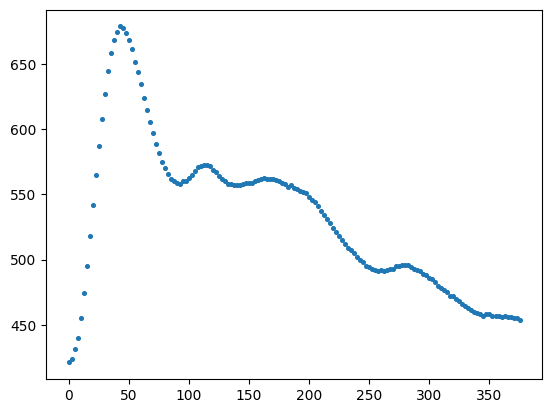

In [7]:
vda  = np.loadtxt('samplesVDA1.txt',int)
cant_datos = vda.shape[0]
medidas_x_segundo = 400
npyarray=np.array
tiempo = np.arange(0,cant_datos/400,1/medidas_x_segundo)
tiempo = tiempo*1000
vda = vda.reshape(-1,1)
tiempo = tiempo.reshape(-1,1)
data = np.hstack((tiempo,vda))
data
plt.scatter(data[:,0],data[:,1],s=7)

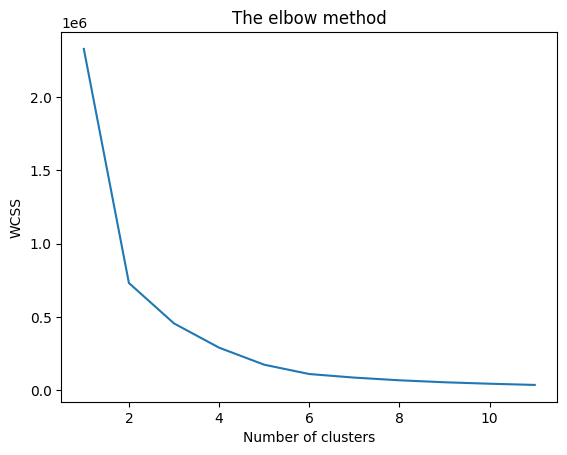

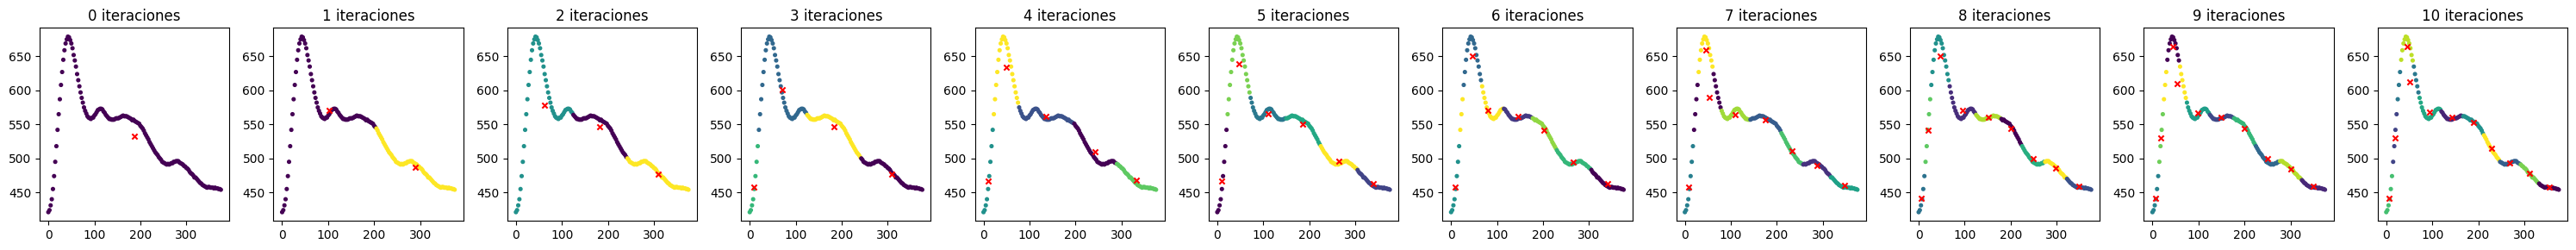

In [10]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
array_etiquetas= []
array_centroides = []
wcss = []
cant_clusters = range(1, 12)
for i in cant_clusters:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(data)
    array_etiquetas.append(kmeans.labels_)
    array_centroides.append(kmeans.cluster_centers_)
    wcss.append(kmeans.inertia_)

plt.plot(cant_clusters, wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()


plots = len(cant_clusters)
columnas = plots

fig, axs = plt.subplots(1, columnas,figsize=(30, 3))

for i in range(columnas):
    axs[i].scatter(data[:, 0], data[:, 1], c=array_etiquetas[i], cmap='viridis', s = 7)
    axs[i].scatter(array_centroides[i][:, 0], array_centroides[i][:, 1], c='red', marker='x', s=20)
    axs[i].set_title(f'{i} iteraciones')
    
plt.tight_layout()
plt.show()
    

#Duda
Porque los centroides salen al reves?? puse la cantidad de iteraciones en 15 y rotaban el orden de axis

# ======== Duda ========
 * Podemos hacer copy paste del codigo? *

 * clustering con otro metodo? tiene mas sentido?* 

 * Como ploteo mejor esto? *

 * Steps de clusteirng con sklearn *  

 * si normalizamos cambia el grafico? * 

 * podemos tomar aunque el cluster tome de los 2 lados? * 
 

In [12]:
"""Subtractive Clustering Algorithm"""

def subclust3(data, Ra, Rb, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

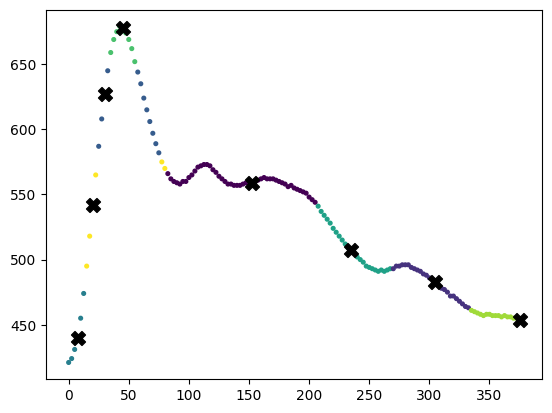

In [252]:

r,c = subclust3(data,0.5,0)
plt.figure()
plt.scatter(data[:,1],data[:,0], c=r, s=7)
plt.scatter(c[:,1],c[:,0], marker='X',s=100,c="black")
plt.show()

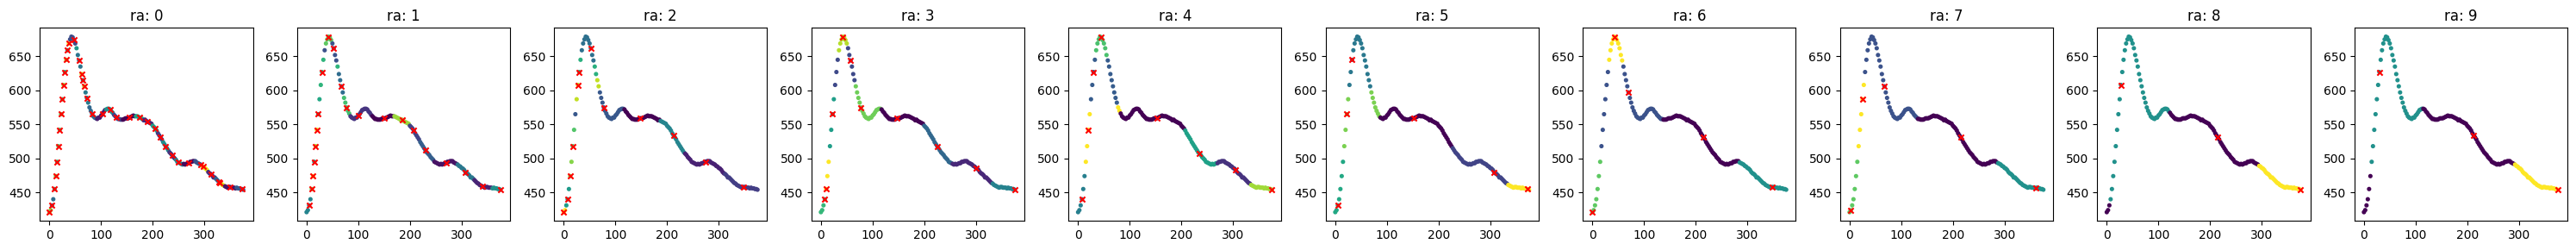

In [16]:
array_etiquetas= []
array_centroides = []
wcss = []
cant_clusters = range(1, 11)
for i in cant_clusters:
    etiquetas, centroides = subclust3(data,i/10,0)
    array_etiquetas.append(etiquetas)
    array_centroides.append(centroides)

plots = len(cant_clusters)
columnas = plots

fig, axs = plt.subplots(1, columnas,figsize=(30, 3))

for i in range(columnas):
    axs[i].scatter(data[:, 0], data[:, 1], c=array_etiquetas[i], cmap='viridis', s = 7)
    axs[i].scatter(array_centroides[i][:, 0], array_centroides[i][:, 1], c='red', marker='x', s=20)
    axs[i].set_title(f'ra: {i}')
    
plt.tight_layout()
plt.show()
    